In [1]:
! pip install surprise

! pip install scikit-surprise

In [2]:
# allows us to access dataframes
import pandas as pd

# specialized class for handling sparse matrices (compressed)
from scipy.sparse import csr_matrix

# Library for visualizing charts
import matplotlib.pylab as plt


# Gives us access to the unsupervised algorithm knn 
from sklearn.neighbors import NearestNeighbors

# Surprise is an easy-to-use Python scikit for recommender systems.
from surprise import SVD #SVD algorithm
from surprise import KNNBasic # Knn algorithm
from surprise import Dataset # Utility for loading datasets
from surprise import Reader # Allows surprise to interpret the ratings
from surprise.model_selection import cross_validate # cross validation utility

import numpy as np
import numpy as np # linear algebra

In [3]:
# https://www.kaggle.com/datasets/tamber/steam-video-games/data

steam = pd.read_csv("/Users/ckabandala/Desktop/FILES/PMDSA/PMDSA Files/Practical ML/Recommender system/steam-200k2.csv")
steam = steam.drop_duplicates() #remove duplicate rows
steam.dtypes

user_id            int64
game_title        object
behavior_name     object
value            float64
dtype: object

In [4]:
steam.head()

,user_id,game_title,behavior_name,value
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0


### Exploration Data Analysis

In [5]:
num_users = len(steam.user_id.unique())
num_games = len(steam.game_title.unique())

print('There are {} unique users and {} unique games in this data set'.format(num_users, num_games))

There are 12393 unique users and 5155 unique games in this data set


In [6]:
steam.head()

,user_id,game_title,behavior_name,value
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0


array([[<Axes: title={'center': 'game_title'}>]], dtype=object)

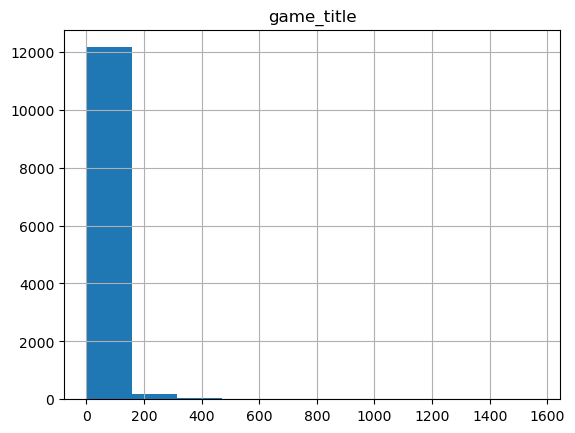

In [7]:
steam[['user_id', 'game_title']].groupby(['user_id']).count().hist()

In [8]:
steam[['user_id', 'game_title']].groupby(['user_id']).count().describe()

,game_title
count,12393.000000
mean,16.081094
std,51.653103
min,1.000000
25%,2.000000
50%,3.000000
75%,9.000000
max,1566.000000


In [9]:
steam.nunique()

user_id          12393
game_title        5155
behavior_name        2
value             1593
dtype: int64

<Axes: ylabel='behavior_name'>

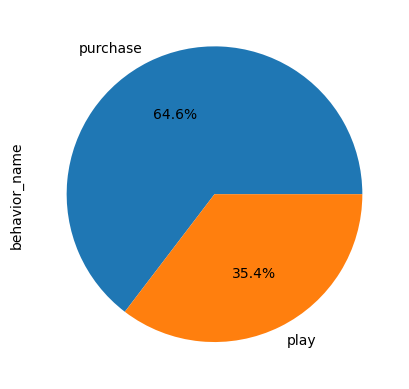

In [10]:
steam["behavior_name"].value_counts().plot(kind ='pie',autopct = '%1.1f%%')

In [11]:
steam['game_title'].unique()

array(['The Elder Scrolls V Skyrim', 'Fallout 4', 'Spore', ...,
       'Space Colony', 'Life is Hard', 'Executive Assault'], dtype=object)

In [12]:
steam['game_title'].value_counts()

# 5155 unique games

Dota 2                             9682
Team Fortress 2                    4646
Counter-Strike Global Offensive    2789
Unturned                           2632
Left 4 Dead 2                      1752
                                   ... 
Putt-Putt Joins the Parade            1
Ducati World Championship             1
Chunk of Change Knight                1
STASIS                                1
Soccertron                            1
Name: game_title, Length: 5155, dtype: int64

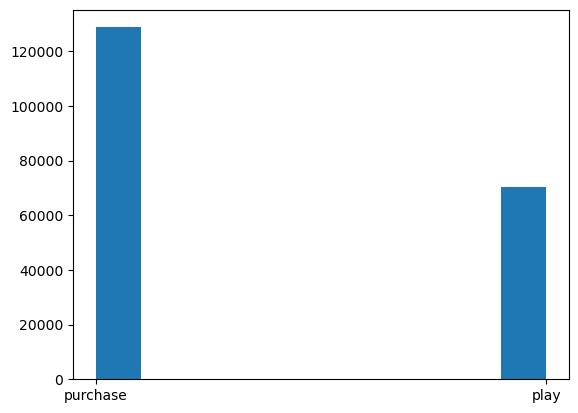

In [13]:
for i in ['behavior_name']:
    plt.hist(steam[i])
    plt.show()

<Axes: >

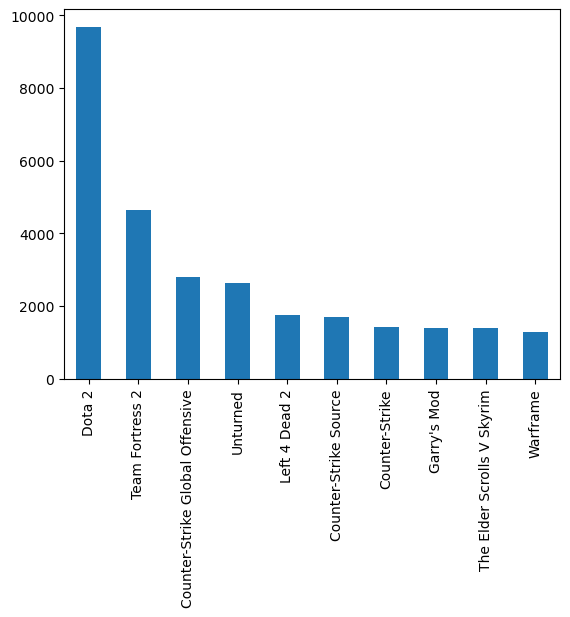

In [14]:
# Top 15 games

steam['game_title'].value_counts().head(10).plot(kind = 'bar')

<Axes: ylabel='game_title'>

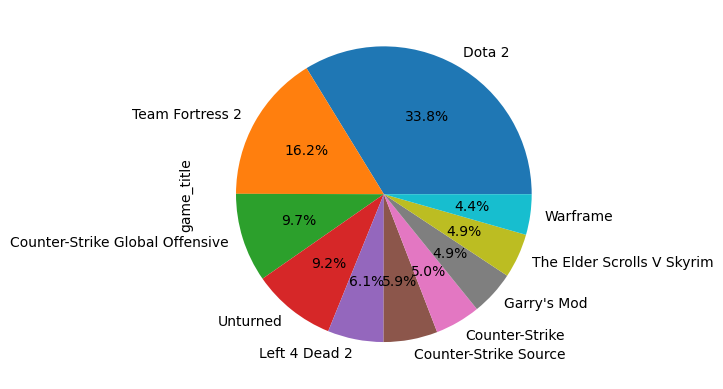

In [15]:
steam['game_title'].value_counts().head(10).plot(kind = 'pie', autopct = '%1.1f%%')

### Data Prepocessing

### Converting playing hours into rating

In [16]:
steam = steam[(steam['value'] >= 2) & (steam['behavior_name'] == 'play')]

steam = steam[steam.groupby('game_title').user_id.transform(len)>=20]

steam['game_title'].nunique()

431

In [17]:
steam['game_title'] = steam['game_title'].astype(str)

In [18]:
average = steam.groupby(['game_title'], as_index = False).value.mean()

average.head()

,game_title,value
0,7 Days to Die,50.777500
1,APB Reloaded,113.377778
2,ARK Survival Evolved,105.982812
3,Ace of Spades,10.971739
4,AdVenture Capitalist,67.760674


In [19]:
steam = steam.merge(average,on = 'game_title')

In [20]:
steam

,user_id,game_title,behavior_name,value_x,value_y
0,151603712,The Elder Scrolls V Skyrim,play,273.0,115.351792
1,59945701,The Elder Scrolls V Skyrim,play,58.0,115.351792
2,92107940,The Elder Scrolls V Skyrim,play,110.0,115.351792
3,250006052,The Elder Scrolls V Skyrim,play,465.0,115.351792
4,11373749,The Elder Scrolls V Skyrim,play,220.0,115.351792
...,...,...,...,...,...
36540,51822361,"Warhammer 40,000 Dawn of War Soulstorm",play,23.0,14.109091
36541,38317154,"Warhammer 40,000 Dawn of War Soulstorm",play,5.5,14.109091
36542,36404933,"Warhammer 40,000 Dawn of War Soulstorm",play,5.8,14.109091
36543,87201181,"Warhammer 40,000 Dawn of War Soulstorm",play,24.0,14.109091


In [21]:
condition = [
    steam['value_x']>= (0.8*steam['value_y']),
   (steam['value_x']>=0.6*steam['value_y'])&(steam['value_x']<0.8*steam['value_y']),
   (steam['value_x']>=0.4*steam['value_y'])&(steam['value_x']<0.6*steam['value_y']),
   (steam['value_x']>=0.2*steam['value_y'])&(steam['value_x']<0.4*steam['value_y']),
    steam['value_x']>=0
    
]
values = [5,4,3,2,1]
steam['rating'] = np.select(condition,values)

In [22]:
steam.columns

Index(['user_id', 'game_title', 'behavior_name', 'value_x', 'value_y',
       'rating'],
      dtype='object')

In [23]:
steam.drop(columns = [ 'behavior_name', 'value_x', 'value_y'],inplace =True )

In [24]:
steam.head()

,user_id,game_title,rating
0,151603712,The Elder Scrolls V Skyrim,5
1,59945701,The Elder Scrolls V Skyrim,3
2,92107940,The Elder Scrolls V Skyrim,5
3,250006052,The Elder Scrolls V Skyrim,5
4,11373749,The Elder Scrolls V Skyrim,5


### Collaborative Filtering using KNN

In [25]:
from sklearn.metrics.pairwise import pairwise_distances,cosine_similarity
from scipy.spatial.distance import cosine,correlation

In [26]:
pv = steam.pivot_table(index=['user_id'],columns=['game_title'],values = 'rating')

In [27]:
pv = pv.apply(lambda x: (x-np.mean(x))/(np.max(x)-np.min(x)),axis=1)

pv = pv.fillna(0)
pv = pv.T
pv = pv.loc[:,(pv != 0).any(axis=0)]

In [28]:
pv.head()

user_id,5250,76767,86540,229911,298950,547685,554278,561758,748719,871990,...,300708628,301801801,302228798,302363079,302378981,302980730,303525289,304971849,305912574,309404240
game_title,,,,,,,,,,,,,,,,,,,,,
7 Days to Die,0.0,0.0,0.0,0.0,-0.314815,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
APB Reloaded,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
ARK Survival Evolved,0.0,0.0,0.0,0.0,-0.314815,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.000000,-0.5,0.0
Ace of Spades,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AdVenture Capitalist,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,0.0,0.0


In [29]:
import scipy as sp
import operator

In [30]:
# converting data into sparse matrix format 
pv_sparse = sp.sparse.csr_matrix(pv.values)

In [31]:
knn = NearestNeighbors(algorithm='brute',leaf_size=30,metric='cosine',metric_params=None,n_jobs=-1,n_neighbors=20,p=2,radius=1)
knn.fit(pv)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20,
                 radius=1)

In [32]:
qury = np.random.choice(pv.shape[0])
print("The Chosen Game = ",pv.index[qury])

The Chosen Game =  Europa Universalis IV


In [34]:
distance , indices = knn.kneighbors(pv.iloc[qury,:].values.reshape(1,-1),n_neighbors=6)

In [35]:
for i in range(0,len(distance.flatten())):
    if i == 0:
        print('Recommendation for {0} \n'.format(pv.index[qury]))
    else:
        print('{0} : {1} with distance of {2}'.format(i,pv.index[indices.flatten()[i]], distance.flatten()[i]))

Recommendation for Europa Universalis IV 

1 : Wargame Red Dragon with distance of 0.8636030296221433
2 : Sid Meier's Civilization IV Beyond the Sword with distance of 0.880795366674946
3 : Medieval II Total War Kingdoms with distance of 0.8878630660219178
4 : Supreme Commander Forged Alliance with distance of 0.9003593113181042
5 : Dragon Age Origins - Ultimate Edition with distance of 0.9096480336575625


In [36]:
game = Reader(rating_scale = (1, 5))

data = Dataset.load_from_df(steam[['user_id', 'game_title', 'rating']], game)

knnbasic = KNNBasic()

knn_results = cross_validate(knnbasic, data, measures = ['RMSE'], cv = 5, verbose = True)

knn_results = cross_validate(knnbasic, data, measures=['RMSE'], cv=5, verbose=True)
knn_results

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.6345  1.6404  1.6360  1.6294  1.6300  1.6340  0.0041  
Fit time          0.62    0.53    0.45    0.42    0.48    0.50    0.07    
Test time         0.35    0.34    0.34    0.33    0.35    0.34    0.01    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similari

{'test_rmse': array([1.63728293, 1.62545877, 1.64006492, 1.63400957, 1.63110516]),
 'fit_time': (0.47536420822143555,
  0.5165212154388428,
  0.49097394943237305,
  0.449146032333374,
  0.4845108985900879),
 'test_time': (0.3492319583892822,
  0.3615710735321045,
  0.33926892280578613,
  0.33721208572387695,
  0.34535694122314453)}

### Top n predictions and the hit rate

In [37]:
from collections import defaultdict

In [38]:
def get_top_n(predictions, n=10):

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        # top_n = is a dictionary to map rating to a userid as key
        # est = predicted rating
        # iid = movie id
        # uid = user id
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        
        # x[1] refers to the est score, which means sort highest to lowest using the rating per user
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [40]:
from surprise.model_selection import LeaveOneOut

In [41]:
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(steam[['user_id', 'game_title', 'rating']], game)

#Build a "leave one out" train/test split for evaluating top-N recommenders
LOOCV = LeaveOneOut(n_splits = 1, random_state = 1, min_n_ratings = 1)
for train, test in LOOCV.split(data):
    LOOCVTrain = train
    LOOCVTest = test

#Save leave one out test predictions
leftoutpredictions = LOOCVTest


#And build an anti-test-set for building predictions
LOOCVAntiTestSet = LOOCVTrain.build_anti_testset()


# generate two models
knn = KNNBasic()

# fit using generated training set from data
knn.fit(LOOCVTrain)

# Then predict ratings for all pairs (u, i) that are NOT in the training set (from data)
#testset = trainset.build_anti_testset()

# generate predictions
knn_predictions = knn.test(LOOCVAntiTestSet)


Computing the msd similarity matrix...
Done computing similarity matrix.


In [42]:
# generate top ten recommendations based on users NOT in the training set
knn_top_n = get_top_n(knn_predictions, n=10)

# Print the recommended items for each user
print("")
print("top n recommendations for knn")
for uid, user_ratings in knn_top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])


top n recommendations for knn
151603712 ['Brothers - A Tale of Two Sons', 'The Wolf Among Us', 'Football Manager 2016', 'Gunpoint', 'LIMBO', 'NARUTO SHIPPUDEN Ultimate Ninja STORM 3 Full Burst', 'Total War ATTILA', 'Half-Life Source', 'Democracy 3', 'The Walking Dead Season Two']
59945701 ['Football Manager 2013', 'Brothers - A Tale of Two Sons', 'Aftermath', 'The Wolf Among Us', 'The Darkness II', 'LIMBO', 'Football Manager 2016', 'GunZ 2 The Second Duel', 'Monaco', 'Gunpoint']
92107940 ['Football Manager 2016', 'Half-Life Source', 'DiRT 2', 'Tropico 5', 'Gunpoint', 'Brothers - A Tale of Two Sons', 'Farming Simulator 2013', 'Football Manager 2013', 'GunZ 2 The Second Duel', 'Bastion']
250006052 ['L.A. Noire', 'Sleeping Dogs', 'The Witcher 2 Assassins of Kings Enhanced Edition', 'Kingdoms of Amalur Reckoning', 'Banished', 'Deus Ex Human Revolution', 'Batman Arkham Asylum GOTY Edition', "Tom Clancy's Splinter Cell Conviction", 'DC Universe Online', 'Darksiders II']
11373749 ['Brothers 

In [43]:
# utility function to get the movie title based on the game_title
def get_title_from_id(idx):
    return steam[steam['game_title']==idx]['title'].values[0]

In [44]:
data = Dataset.load_from_df(steam[['user_id', 'game_title', 'rating']], game)

In [45]:
def hitrate(topNpredictions, leftoutpredictions):

    userHitRates = []

    leftoutGameTitles_list = []


    for leftout in leftoutpredictions:

        uid = leftout[0]
        leftoutgametitle = leftout[1]

        print("uid: ", uid)
        print("played: ", leftoutgametitle)

        predictedGame_Titles = []
        for predGameTitle, predRating in knn_top_n[uid]:
            predictedGame_Titles.append(predGameTitle)

        print(predictedGame_Titles)
        hits = len(set([leftoutgametitle]).intersection(predictedGame_Titles))
        total = len(predictedGame_Titles)
        userHitRate = hits/total

        userhitRate_dict = {"uid": uid, "userhitrate": userHitRate}
        userHitRates.append(userhitRate_dict)

    return pd.DataFrame(userHitRates)

In [46]:
knn_top_n[5]

[]

In [47]:
print("KNN hitrate metrics")
hitrate(knn_top_n, leftoutpredictions)

KNN hitrate metrics
uid:  151603712
played:  Path of Exile
['Brothers - A Tale of Two Sons', 'The Wolf Among Us', 'Football Manager 2016', 'Gunpoint', 'LIMBO', 'NARUTO SHIPPUDEN Ultimate Ninja STORM 3 Full Burst', 'Total War ATTILA', 'Half-Life Source', 'Democracy 3', 'The Walking Dead Season Two']
uid:  59945701
played:  Counter-Strike Global Offensive
['Football Manager 2013', 'Brothers - A Tale of Two Sons', 'Aftermath', 'The Wolf Among Us', 'The Darkness II', 'LIMBO', 'Football Manager 2016', 'GunZ 2 The Second Duel', 'Monaco', 'Gunpoint']
uid:  92107940
played:  Garry's Mod
['Football Manager 2016', 'Half-Life Source', 'DiRT 2', 'Tropico 5', 'Gunpoint', 'Brothers - A Tale of Two Sons', 'Farming Simulator 2013', 'Football Manager 2013', 'GunZ 2 The Second Duel', 'Bastion']
uid:  250006052
played:  The Elder Scrolls V Skyrim
['L.A. Noire', 'Sleeping Dogs', 'The Witcher 2 Assassins of Kings Enhanced Edition', 'Kingdoms of Amalur Reckoning', 'Banished', 'Deus Ex Human Revolution', 'Ba

,uid,userhitrate
0,151603712,0.0
1,59945701,0.0
2,92107940,0.0
3,250006052,0.0
4,11373749,0.0
...,...,...
3453,141721441,0.0
3454,219145315,0.0
3455,216505571,0.0
3456,207036748,0.0
